In [1]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.visualization import plot_histogram
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options
import qiskit_aer.noise as noise

import torch

In [2]:
# setup the number of qubits and the fake backend
num_qubits = 2
fake_backend = GenericBackendV2(
    num_qubits=2,
    basis_gates=["id", "rz", "rx", "ry", "cx", "h", "sx"],
    coupling_map=[[0,1]]
)

# set the noise model from the backend
noise_model = noise.NoiseModel.from_backend(fake_backend)

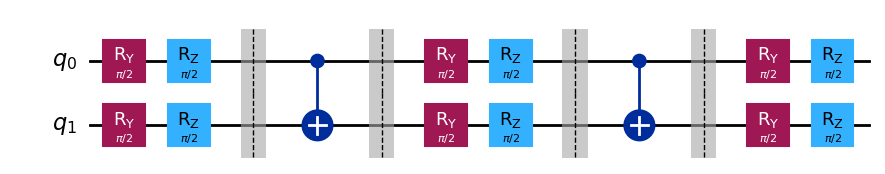

In [3]:
def ansatz(num_qubits, circuit_depth, theta1, theta2):

    # create a num_qubit qubit circuit
    circuit = QuantumCircuit(num_qubits)
        
    # apply the initial tuning gates Ry & Rz
    for i in range(num_qubits):
        circuit.ry(theta1, i)
        circuit.rz(theta1, i)
        
    # apply the depth-dependent CX (or Toffoli gates) and tuning gates
    for i in range(circuit_depth):
        # barrier added for "prettier" output
        circuit.barrier()
        for j in range(num_qubits-1, -1, -1):
            if(j!=0):
                circuit.cx(j-1, j)
        circuit.barrier()
        for j in range(num_qubits):
            circuit.ry(theta2, j)
            circuit.rz(theta2, j)
            
    return circuit

# see how the circuit looks
qr = QuantumRegister(2, "qr")
cr = ClassicalRegister(2, "cr")
qc = QuantumCircuit(qr, cr)

circuit = ansatz(2, 2, pi/2, pi/2)
circuit.draw(output="mpl")

In [4]:
# this is for future use with real IBM backends
USE_REAL_HARDWARE = False

# get the backend
backend = AerSimulator.from_backend(fake_backend)

print(backend)

AerSimulator('aer_simulator_from(generic_backend_2q)'
             noise_model=<NoiseModel on ['sx', 'h', 'ry', 'measure', 'id', 'cx', 'rx']>)


In [5]:
def measure_circuit(circuit):
    """
        returns a copy of the circuit with measurement on all qubits.
    """
    measure = circuit.copy()
    measure.measure_all()
    return measure

def pauli_measures(circuit, operator, shots=32000):
    """
        measures expectation value of the given operator: 'XX', 'ZZ', 'II' etc.
    """
    qc = circuit.copy()
    if operator == 'XX':
        qc.h(0)
        qc.h(1)

    # measure the circuit
    measured = measure_circuit(qc)
    # transpile the circuit with the backend and the basis gates (sx, h, id and cx are default)
    compiled = transpile(measured, backend = backend,
                         basis_gates=["id", "rz", "rx", "ry", "cx", "h", "sx"],
                         coupling_map=[[0,1]])
    job = backend.run(compiled, noise_model=noise_model, shots=shots)
    result = job.result()
    counts = result.get_counts()

    # ensure we have 4 outcomes counted
    for outcome in ['00', '01', '10', '11']:
        if outcome not in counts:
            counts[outcome] = 0

    total = sum(counts.values())
    if total == 0:
        return 0.0

    # add up the counts in accordance with the observables
    if operator == "ZZ":
        val = counts['00'] - counts['01'] - counts['10'] + counts['11']
    elif operator == "IZ":
        val = counts['00'] - counts['01'] + counts['10'] - counts['11']
    elif operator == "ZI":
        val = counts['00'] + counts['01'] - counts['10'] - counts['11']
    elif operator == "II":
        val = counts['00'] + counts['01'] + counts['10'] + counts['11']
    elif operator == "XX":
        val = counts['00'] - counts['01'] - counts['10'] + counts['11']
    else:
        raise ValueError("Invalid operator:", operator)

    return val / total

In [6]:
# set up the coefficients for each observable (gotten online [FIND LINK])
coeffs = {'c0': -1.0523732, 'c1': 0.39793742, 'c2': -0.3979374, 'c3': -0.0112801, 'c4': 0.18093119}

# R=0.75A
nuclear_repulsion = 0.7199689944489797

In [7]:
def hamiltonian(params):
    """
        evaluate E = <H> = c0*II + c1*IZ + c2*ZI + c3*ZZ + c4*XX
    """
    return (coeffs['c0']*params["II"] +
            coeffs['c1']*params["IZ"] +
            coeffs['c2']*params["ZI"] +
            coeffs['c3']*params["ZZ"] +
            coeffs['c4']*params["XX"])

In [8]:
vqe_noisy_list = list()
vqe_ideal_list = list()
noisy = False

def vqe_step(angles, num_qubits = 2, circuit_depth = 5, verbose = True):
# def vqe_step(theta1, verbose = True):
    """
        executes the VQE algorithm. 
        creates and executes three quantum circuits (one for each of the observables XX, YY and ZZ), then evaluates the energy.
    
        arguments
        -----------
        theta (real): is the parameter parametrizing the trial state
        
        return
        --------
        energy (real): the energy of the system
        qc_list (dict): a dictionary containing the three quantum circuits for the observables XX, YY and ZZ
    """
    # number of executions for each quantum circuit
    shots = 8096

    # intermediate result of VQE
    vqe_res = dict()
    # for plotting the circuits of intermediate results
    qc_list = dict()
    
    for op in ['XX', 'ZZ', 'IZ', 'ZI', 'II']:

        qc = QuantumCircuit(2)
        
        # iplementation of the ansatz
        # qc = ansatz(2, 2, angles[0], angles[1])
        qc = ansatz(num_qubits, circuit_depth, angles[0], angles[1])

        # just for plotting purposes
        qc.barrier()

        # measurements in the appropriate basis (XX, YY, ZZ) are implemented
        op_result = pauli_measures(qc, op, shots)
            
        vqe_res[op] = op_result
        qc_list[op] = qc
        
    energy = hamiltonian(vqe_res)
    
    if noisy == True:
        vqe_noisy_list.append(energy)
    else:
        vqe_ideal_list.append(energy)
    
    if verbose: 
        print("Mean values from measurement results:\n", vqe_res) 
    
        return energy + nuclear_repulsion
#         return energy, qc_list
    
    else: 
        return energy + nuclear_repulsion

In [9]:
import scipy 

vqe_noisy_list = []
noisy = True
# minimize_scalar is for one variable
# optimizer = minimize_scalar(vqe_step, args=(False), options = {'disp':True,'maxiter':203})

# minimize is for multiple variables
# COBYLA gave best results
x0 = [np.pi/2, np.pi/2]
optimizer = scipy.optimize.minimize(vqe_step, x0, args=(2, 2), method = "COBYLA", options = {'disp': True, "maxiter": 1000})

Mean values from measurement results:
 {'XX': -0.9696146245059288, 'ZZ': 0.0014822134387351778, 'IZ': -0.006422924901185771, 'ZI': 0.011116600790513834, 'II': 1.0}
Mean values from measurement results:
 {'XX': -0.278903162055336, 'ZZ': 0.11289525691699605, 'IZ': 0.36561264822134387, 'ZI': -0.23937747035573123, 'II': 1.0}
Mean values from measurement results:
 {'XX': -0.16205533596837945, 'ZZ': -0.026926877470355732, 'IZ': -0.0958498023715415, 'ZI': 0.3740118577075099, 'II': 1.0}
Mean values from measurement results:
 {'XX': -0.5264328063241107, 'ZZ': -0.6442687747035574, 'IZ': 0.6655138339920948, 'ZI': -0.7487648221343873, 'II': 1.0}
Mean values from measurement results:
 {'XX': 0.4258893280632411, 'ZZ': 0.21096837944664032, 'IZ': -0.13142292490118576, 'ZI': 0.6457509881422925, 'II': 1.0}
Mean values from measurement results:
 {'XX': 0.45528656126482214, 'ZZ': -0.07065217391304347, 'IZ': -0.2692687747035573, 'ZI': 0.7178853754940712, 'II': 1.0}
Mean values from measurement results:
 {'

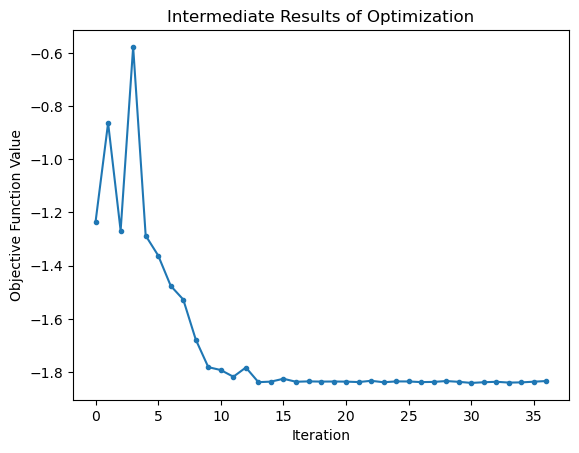

-1.1138215269195975


In [10]:
import matplotlib.pyplot as plt
from scipy import interpolate

plt.plot(range(len(vqe_noisy_list)), vqe_noisy_list, 'o-', markersize = 3)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Intermediate Results of Optimization')
plt.show()

print(optimizer.fun)

-1.8380051298239997 (2 depth) <br>

-1.844160122076 (3 depth)

-1.8458880861599998 (5 depth)

-1.8315977234299998 (10 depth)



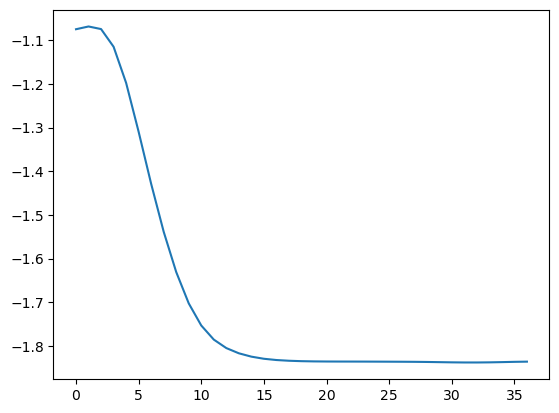

In [11]:
from scipy.ndimage import gaussian_filter1d

vqe_smooth = gaussian_filter1d(vqe_noisy_list, sigma=2)

plt.plot(vqe_smooth)

plt.show()